In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from src.utils.custom_formatter import setup_custom_logger
logger = setup_custom_logger(__name__, level=logging.DEBUG)

- Load dataset to have actual returns and market returns

In [112]:
from src import Analyzer
from src.utils.params import ReturnParams
from src import RiskTests

import numpy as np

return_params = ReturnParams(
    horizons={h for h in range(1,120+1)},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=["VOO"], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


#rt = RiskTests(an)

2025-05-20 18:35:55,315 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)


In [113]:
df_ret = an.build_returns()[0]
df_ret = df_ret.apply(np.exp)
df_ret 

,rh_portfolio,VOO,rh_portfolio_1_return,VOO_1_return,rh_portfolio_2_return,VOO_2_return,rh_portfolio_3_return,VOO_3_return,rh_portfolio_4_return,VOO_4_return,...,rh_portfolio_116_return,VOO_116_return,rh_portfolio_117_return,VOO_117_return,rh_portfolio_118_return,VOO_118_return,rh_portfolio_119_return,VOO_119_return,rh_portfolio_120_return,VOO_120_return
date,,,,,,,,,,,,,,,,,,,,,
2018-05-03,0.993973,1.000000,0.993973,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-04,1.016832,1.013266,1.016832,1.013266,1.010703,1.013266,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-07,1.008523,1.003110,1.008523,1.003110,1.025498,1.016417,1.019317,1.016417,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-08,1.004133,0.999959,1.004133,0.999959,1.012692,1.003069,1.029737,1.016376,1.023530,1.016376,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-09,1.010288,1.009708,1.010288,1.009708,1.014464,1.009667,1.023111,1.012806,1.040331,1.026243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-07,0.996141,1.000521,0.996141,1.000521,0.994643,1.007242,1.009952,1.013520,1.024548,1.017782,...,1.217148,1.037537,1.172040,1.002839,1.157594,0.992444,1.158689,0.988550,1.172409,0.993310
2020-08-10,1.019014,1.003188,1.019014,1.003188,1.015081,1.003711,1.013554,1.010454,1.029155,1.016751,...,1.279781,1.073084,1.240290,1.040845,1.194325,1.006036,1.179604,0.995609,1.180720,0.991702
2020-08-11,0.980078,0.991925,0.980078,0.991925,0.998713,0.995087,0.994859,0.995605,0.993363,1.002294,...,1.266462,1.069144,1.254286,1.064418,1.215582,1.032440,1.170531,0.997912,1.156105,0.987569


In [6]:
import numpy as np
from scipy import stats

def mean_diff_ci(a, b):

    # Sample statistics
    mean_diff = np.mean(a) - np.mean(b)
    n1, n2 = len(a), len(b)
    var1, var2 = np.var(a, ddof=1), np.var(b, ddof=1)  # sample variances

    # Standard error of the difference
    se_diff = np.sqrt(var1/n1 + var2/n2)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df = (var1/n1 + var2/n2)**2 / ((var1**2)/(n1**2 * (n1-1)) + (var2**2)/(n2**2 * (n2-1)))

    # t-critical value for 95% CI
    alpha = 0.05
    t_crit = stats.t.ppf(1 - alpha/2, df)

    # Confidence interval
    ci_lower = mean_diff - t_crit * se_diff
    ci_upper = mean_diff + t_crit * se_diff

    return mean_diff, ci_lower, ci_upper 
    print(f"Mean difference: {mean_diff:.4f}")
    print(f"95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")

Gamma: 2.4810


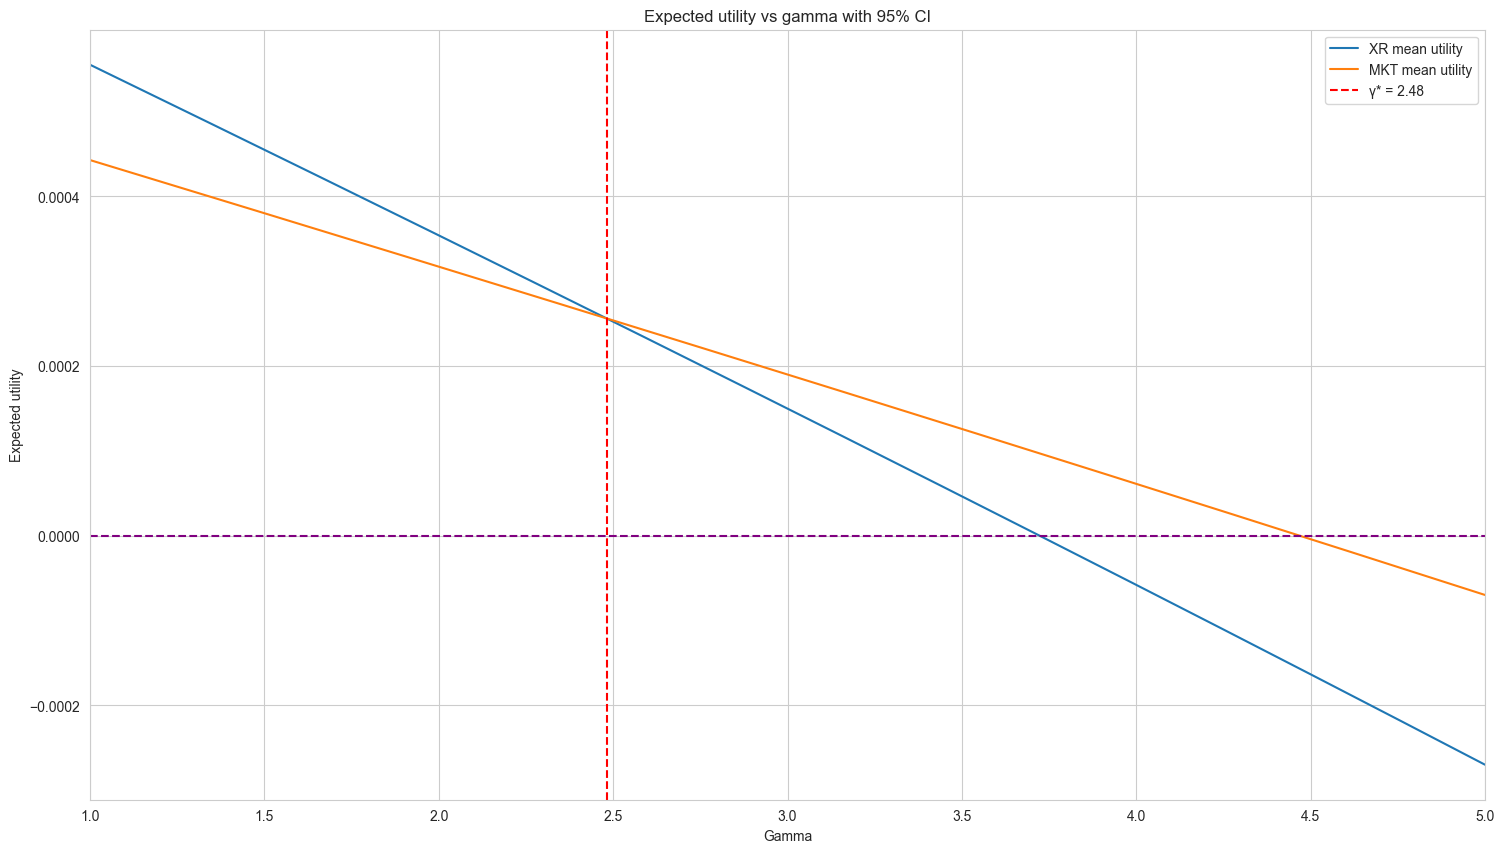

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility
import seaborn as sns

sns.set_style("whitegrid")

d = 1
mkt = f"VOO_{d}_return"
r = f"rh_portfolio_{d}_return"
df = df_ret[[mkt, r]]
parametric = False




# keep the scalar returned by the CE condition
gamma_hat = find_gamma_certainty_equivalent(df[r],
                                            df[mkt],
                                            parametric=parametric)

print(f"Gamma: {gamma_hat:.4f}")

lo = 1
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 1000)

utilities_xr  = []
utilities_xmkt = []
ut_diff = []

for g in gammas:
    #utilities_xr.append(compute_crra_utility(df["xr"], g, mean=True, confint=True))
    #utilities_xmkt.append(compute_crra_utility(df["xmkt"], g, mean=True, confint=True))
    ut_xr = compute_crra_utility(df[r], g, mean=False)
    ut_xmkt = compute_crra_utility(df[mkt], g, mean=False)

    ut_diff.append(mean_diff_ci(ut_xr, ut_xmkt))

    utilities_xr.append(np.mean(ut_xr))
    utilities_xmkt.append(np.mean(ut_xmkt))


means_diff, lo_diff, hi_diff = zip(*ut_diff)
#means_xr, lo_xr, hi_xr = zip(*utilities_xr)
#means_mk, lo_mk, hi_mk = zip(*utilities_xmkt)

means_xr = utilities_xr
means_mk = utilities_xmkt


plot=True

if plot:
    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    plt.plot(gammas, means_xr, label='XR mean utility', color='C0')
    #plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    plt.plot(gammas, means_mk, label='MKT mean utility', color='C1')
    #plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    #plt.plot(gammas, means_diff, label='Difference in mean utility', color='C2')
    #plt.fill_between(gammas, lo_diff, hi_diff, color='C2', alpha=0.2)

    plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    plt.axhline(0, color='purple', linestyle='--')
    plt.xlabel('Gamma')
    plt.xlim((lo,hi))
    plt.ylabel('Expected utility')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()




In [11]:
def certainty_equivalent(utility:float, gamma:float)->float:
    """
    Compute the certainty equivalent from a utility value and a risk aversion parameter
    """
    ce = ((1-gamma)*utility+1)**(1/(1-gamma))

    return ce



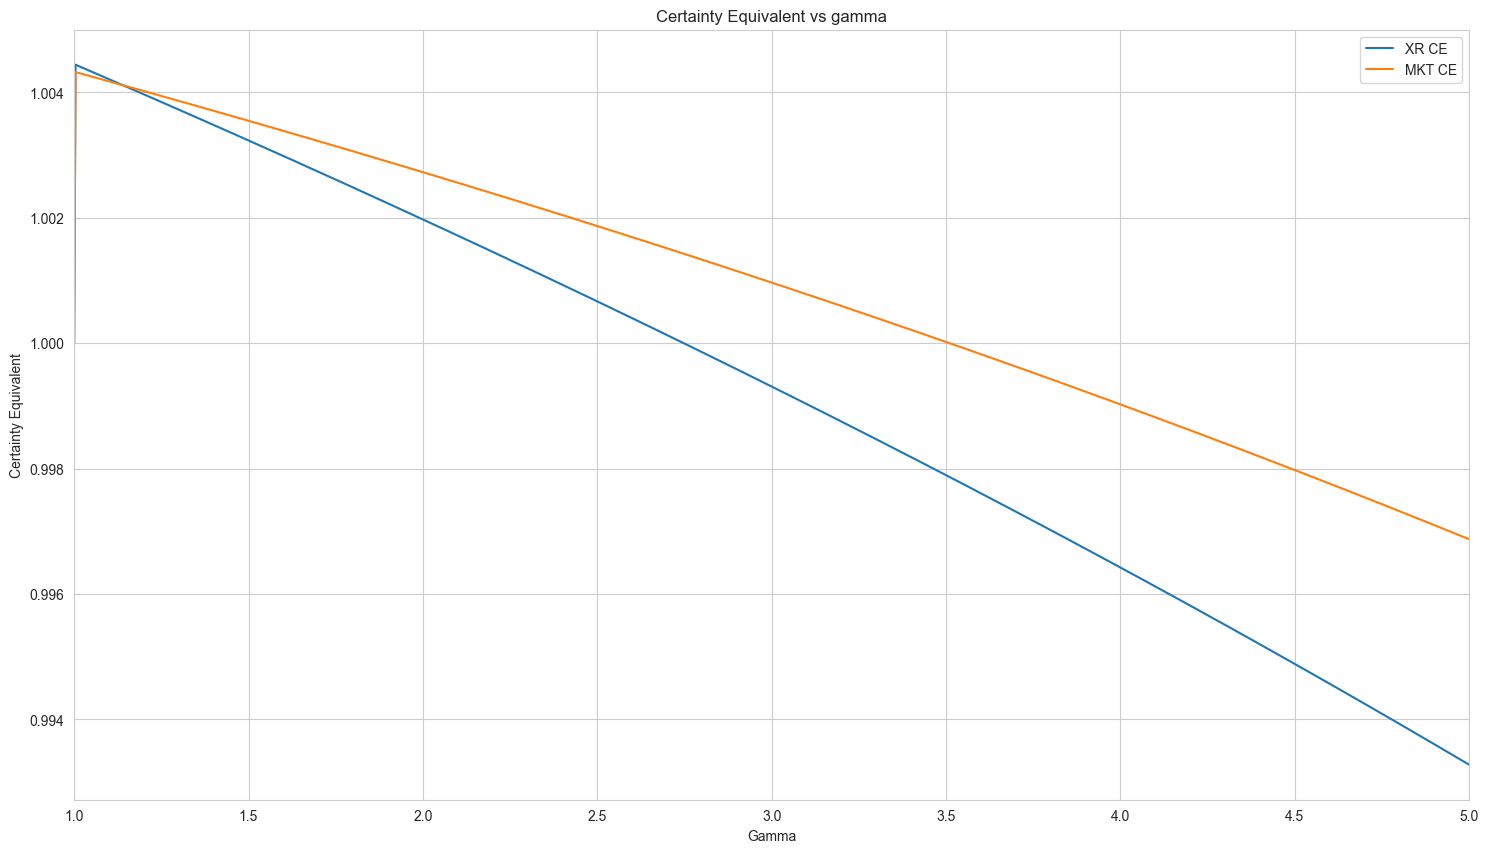

In [131]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility
import seaborn as sns

sns.set_style("whitegrid")



import numpy as np
import matplotlib.pyplot as plt


plot=True

welfare_xr = [certainty_equivalent(means_xr[g], gammas[g]) for g in range(len(gammas))]
welfare_mk = [certainty_equivalent(means_mk[g], gammas[g]) for g in range(len(gammas))]


if plot:
    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    plt.plot(gammas, welfare_xr, label='XR CE', color='C0')
    #plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    plt.plot(gammas, welfare_mk, label='MKT CE', color='C1')
    #plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    #plt.plot(gammas, means_diff, label='Difference in mean utility', color='C2')
    #plt.fill_between(gammas, lo_diff, hi_diff, color='C2', alpha=0.2)

    #plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    #plt.axhline(0, color='purple', linestyle='--')


    #plt.plot(gammas, [m+1 for m in means_xr], label='XR mean utility', color='C2')
    #plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    #plt.plot(gammas, [m+1 for m in means_mk], label='MKT mean utility', color='C3')
    #plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    #plt.plot(gammas, means_diff, label='Difference in mean utility', color='C2')
    #plt.fill_between(gammas, lo_diff, hi_diff, color='C2', alpha=0.2)

    

    plt.xlabel('Gamma')
    plt.xlim((lo,hi))
    plt.ylabel('Certainty Equivalent')
    plt.title('Certainty Equivalent vs gamma')
    plt.legend()
    plt.grid(True)
    plt.show()


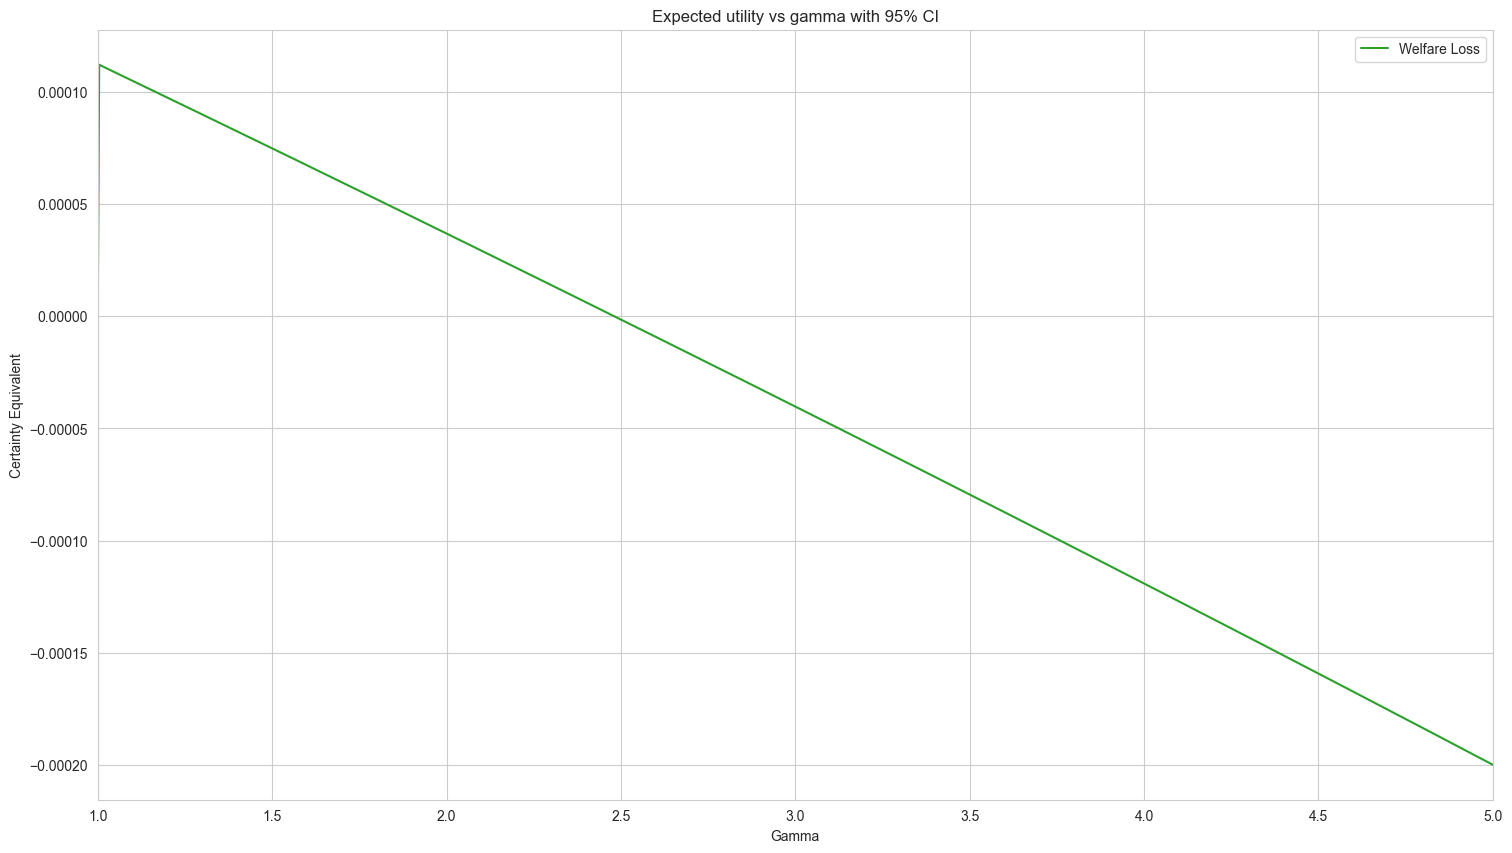

In [135]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility
import seaborn as sns

sns.set_style("whitegrid")



import numpy as np
import matplotlib.pyplot as plt


plot=True

welfare_xr = [certainty_equivalent(means_xr[g], gammas[g]) for g in range(len(gammas))]
welfare_mk = [certainty_equivalent(means_mk[g], gammas[g]) for g in range(len(gammas))]

welfare_loss = [x-m for x,m in zip(welfare_xr, welfare_mk)]

if plot:
    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    #plt.plot(gammas, welfare_xr, label='XR CE', color='C0')
    #plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    #plt.plot(gammas, welfare_mk, label='MKT CE', color='C1')
    #plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)


    plt.plot(gammas, welfare_loss, label='Welfare Loss', color='C2')
    #plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    #plt.axhline(0, color='purple', linestyle='--')



    

    plt.xlabel('Gamma')
    plt.xlim((lo,hi))
    plt.ylabel('Certainty Equivalent')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()


In [140]:
import pandas as pd
from tqdm import tqdm


lo = 1
hi = 5
gap = 5
gammas = np.linspace(lo, hi, 1000)

df_plot = pd.DataFrame(columns=gammas)

for d in tqdm(range(1,120+1)):
    #print(d)

    df = df_ret[[f"rh_portfolio_{d}_return", f"VOO_{d}_return"]].dropna()
    #df = rt.resample_factors(f"{d}D")+1


    utilities_xr  = []
    utilities_xmkt = []
    ut_diff = []

    for g in gammas:
        #utilities_xr.append(compute_crra_utility(df["xr"], g, mean=True, confint=True))
        #utilities_xmkt.append(compute_crra_utility(df["xmkt"], g, mean=True, confint=True))
        ut_xr = compute_crra_utility(df[f"rh_portfolio_{d}_return"], g, mean=False)
        ut_xmkt = compute_crra_utility(df[f"VOO_{d}_return"], g, mean=False)

        ut_diff.append(mean_diff_ci(ut_xr, ut_xmkt))

        utilities_xr.append(np.mean(ut_xr))
        utilities_xmkt.append(np.mean(ut_xmkt))


    welfare_xr = [certainty_equivalent(utilities_xr[g], gammas[g]) for g in range(len(gammas))]
    welfare_mk = [certainty_equivalent(utilities_xmkt[g], gammas[g]) for g in range(len(gammas))]

    welfare_loss = [x-m for x,m in zip(welfare_xr, welfare_mk)]
    #welfare_loss = [x-1 for x in welfare_xr]

    df_plot.loc[d,:] = welfare_loss


100%|██████████| 120/120 [00:57<00:00,  2.08it/s]


In [141]:
df_plot = df_plot.apply(pd.to_numeric, errors='coerce')
df_plot.columns = [format(c, ".2f") for c in df_plot.columns]
df_numeric = df_plot
df_numeric = df_numeric.replace(0, 0.00000000000000001)
df_numeric


,1.00,1.00,1.01,1.01,1.02,1.02,1.02,1.03,1.03,1.04,...,4.96,4.97,4.97,4.98,4.98,4.98,4.99,4.99,5.00,5.00
1,1.000000e-17,0.000112,0.000112,0.000112,0.000111,0.000111,0.000111,0.000110,0.000110,0.000110,...,-0.000197,-0.000197,-0.000198,-0.000198,-0.000198,-0.000199,-0.000199,-0.000199,-0.000200,-0.000200
2,1.000000e-17,0.000225,0.000224,0.000223,0.000222,0.000222,0.000221,0.000220,0.000219,0.000218,...,-0.000575,-0.000576,-0.000576,-0.000577,-0.000578,-0.000579,-0.000580,-0.000581,-0.000581,-0.000582
3,1.000000e-17,0.000344,0.000342,0.000341,0.000340,0.000338,0.000337,0.000335,0.000334,0.000333,...,-0.001081,-0.001082,-0.001084,-0.001085,-0.001087,-0.001088,-0.001090,-0.001091,-0.001093,-0.001094
4,1.000000e-17,0.000475,0.000473,0.000472,0.000470,0.000468,0.000466,0.000464,0.000462,0.000460,...,-0.001509,-0.001511,-0.001514,-0.001516,-0.001518,-0.001520,-0.001522,-0.001524,-0.001526,-0.001528
5,1.000000e-17,0.000572,0.000569,0.000567,0.000564,0.000562,0.000559,0.000556,0.000554,0.000551,...,-0.002127,-0.002130,-0.002133,-0.002136,-0.002138,-0.002141,-0.002144,-0.002147,-0.002150,-0.002153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1.000000e-17,-0.017003,-0.017016,-0.017029,-0.017043,-0.017056,-0.017069,-0.017082,-0.017096,-0.017109,...,-0.031668,-0.031685,-0.031702,-0.031719,-0.031736,-0.031753,-0.031770,-0.031787,-0.031804,-0.031821
117,1.000000e-17,-0.017332,-0.017345,-0.017359,-0.017372,-0.017385,-0.017399,-0.017412,-0.017425,-0.017438,...,-0.032266,-0.032284,-0.032302,-0.032319,-0.032337,-0.032354,-0.032372,-0.032389,-0.032407,-0.032425
118,1.000000e-17,-0.017680,-0.017693,-0.017707,-0.017720,-0.017733,-0.017747,-0.017760,-0.017773,-0.017787,...,-0.032854,-0.032872,-0.032890,-0.032908,-0.032926,-0.032944,-0.032962,-0.032980,-0.032998,-0.033016
119,1.000000e-17,-0.018008,-0.018021,-0.018035,-0.018048,-0.018062,-0.018075,-0.018089,-0.018102,-0.018115,...,-0.033408,-0.033427,-0.033445,-0.033464,-0.033482,-0.033500,-0.033519,-0.033537,-0.033556,-0.033574


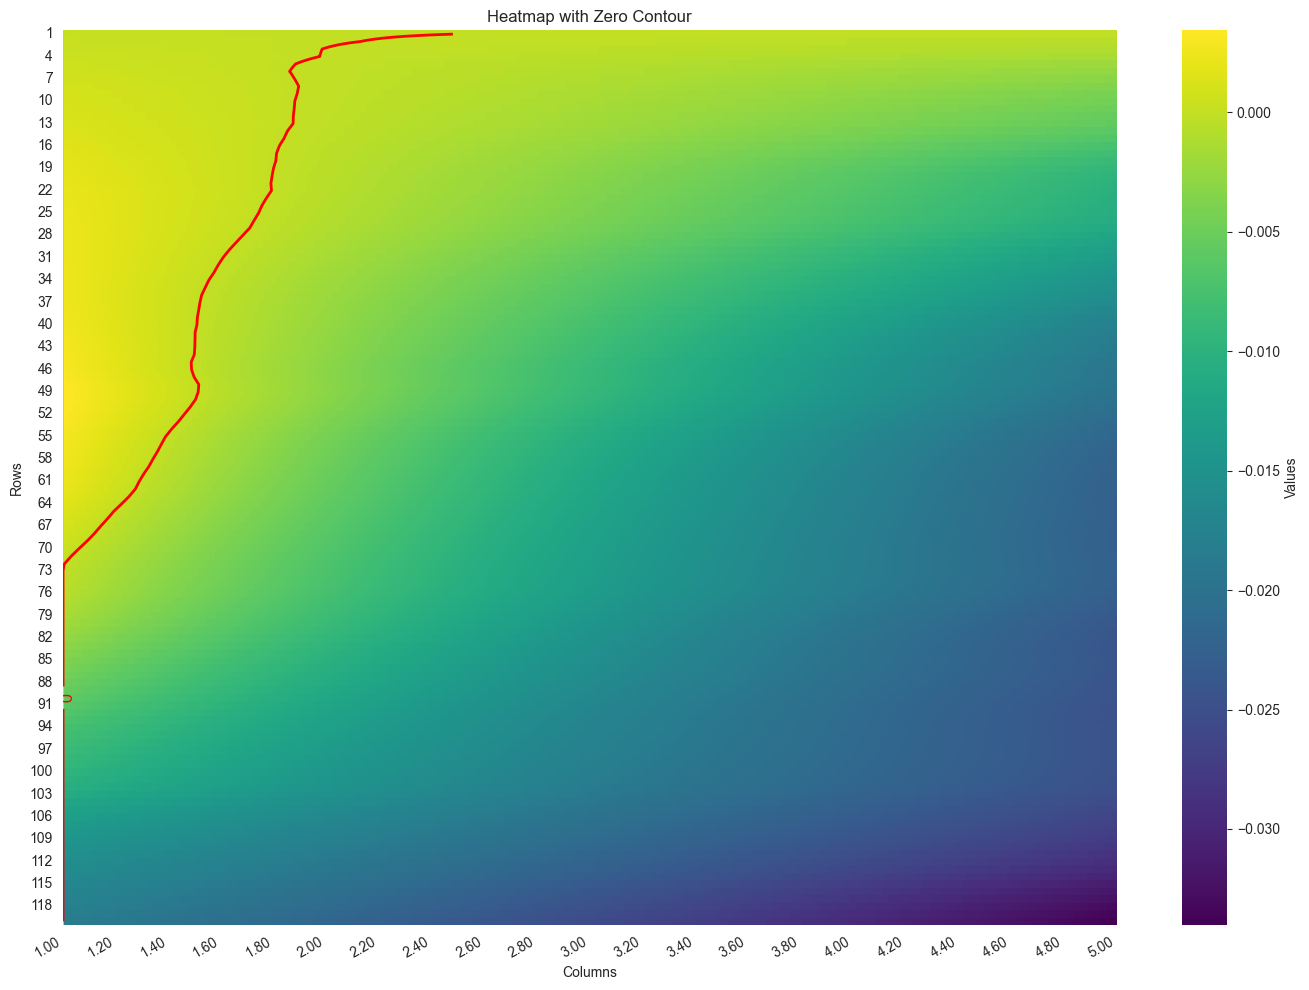

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as mticker

# — assume df_numeric is your fully numeric DataFrame —

# 1) Prepare the X/Y grid for contouring:
X = np.arange(df_numeric.shape[1])
Y = np.arange(df_numeric.shape[0])
Xg, Yg = np.meshgrid(X, Y)

# 2) Plot heatmap:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df_numeric, ax=ax, cmap='viridis', cbar_kws={'label':'Values'})

# 3) Overlay zero‐contour:
#    levels=[0] draws only the line where value == 0
cs = ax.contour(
    Xg + 0.5,         # shift so contours align with cell centers
    Yg + 0.5,
    df_numeric.values,
    levels=[0],
    colors='red',   # pick a contrasting color
    linewidths=2
)

# 4) (Optional) Label the contour:
ax.clabel(cs, colors='red', fontsize=12)

# 5) Tidy up ticks and labels:
#    Show every 5th column tick as before
import numpy as np

positions = np.arange(len(df_plot.columns))[::50]
positions = np.append(positions, len(df_plot.columns))
labels    = df_plot.columns[::50]
labels    = list(labels)
labels.append(df_plot.columns[-1])

ax.set_xticks(positions) 
ax.set_xticklabels(labels, rotation=30, ha='right')
ax.set_xlabel('Columns')
ax.set_ylabel('Rows')
ax.set_title('Heatmap with Zero Contour')

plt.tight_layout()
plt.show()


In [157]:
labels = list(labels)
labels.append("5.00")

labels

['1.00',
 '1.20',
 '1.40',
 '1.60',
 '1.80',
 '2.00',
 '2.20',
 '2.40',
 '2.60',
 '2.80',
 '3.00',
 '3.20',
 '3.40',
 '3.60',
 '3.80',
 '4.00',
 '4.20',
 '4.40',
 '4.60',
 '4.80',
 5,
 '5',
 '5.0',
 '5.00']

ValueError: invalid literal for int() with base 10: '5.00'

In [65]:
positions + 500000000

array([500000000, 500000050, 500000100, 500000150, 500000200, 500000250,
       500000300, 500000350, 500000400, 500000450, 500000500, 500000550,
       500000600, 500000650, 500000700, 500000750, 500000800, 500000850,
       500000900, 500000950])

### All possible timeframes

In [3]:
%load_ext autoreload
%autoreload 2

In [44]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)



2025-05-02 12:41:07,298 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-02 12:41:13,687 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


In [45]:
all_ret_df = rt.build_all_pairs_dataframe()


100%|██████████| 144991/144991 [00:19<00:00, 7497.32it/s] 


Gamma: -5.43728


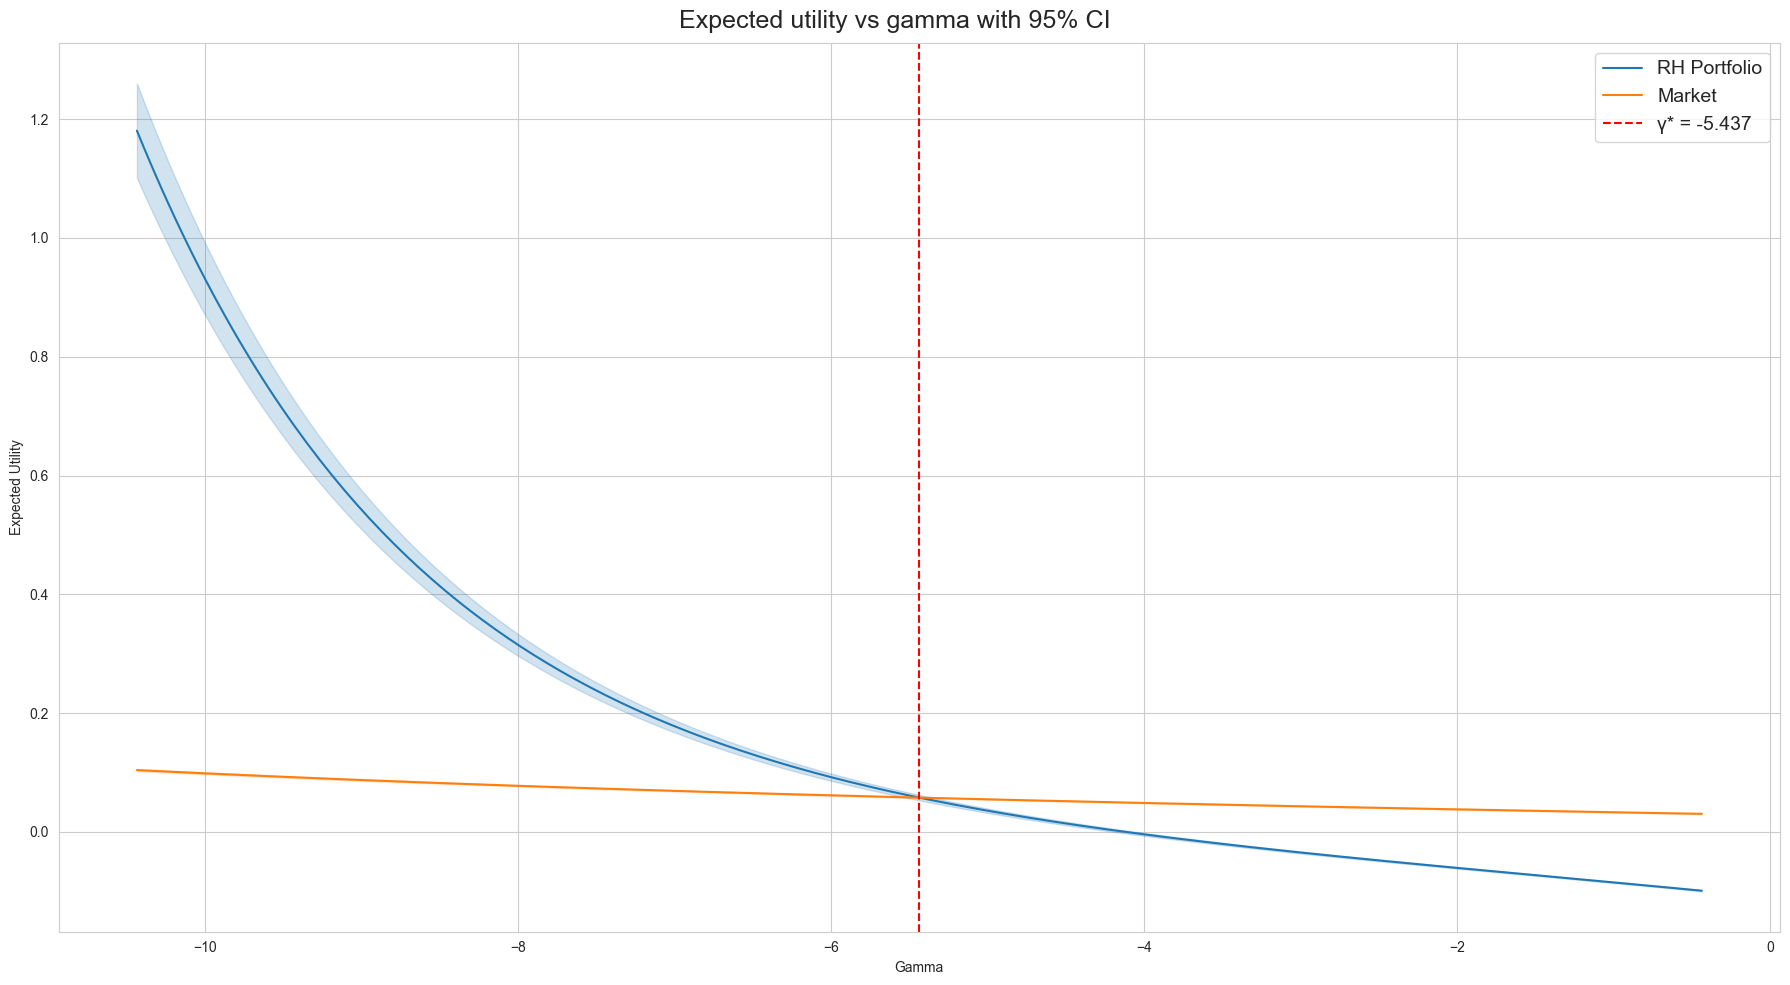

np.float64(-5.437281299436248)

In [46]:

rt.find_cutoff_gamma(df_returns=all_ret_df-1)

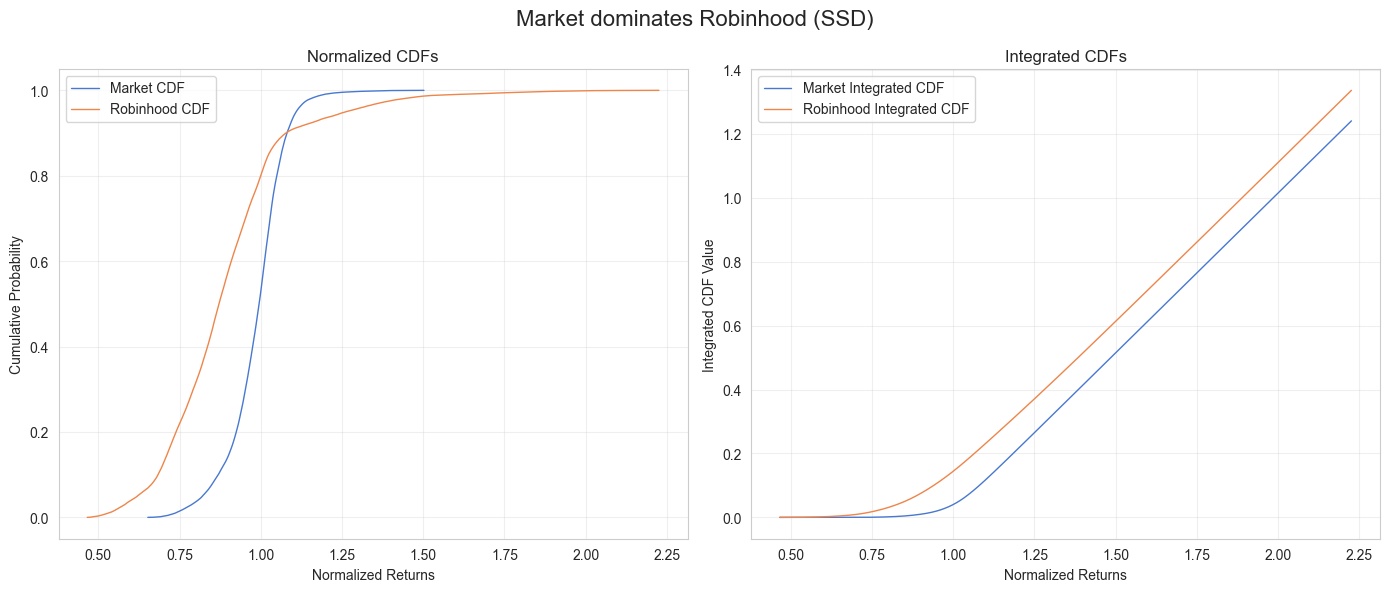

np.True_

In [33]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=all_ret_df, horizons=[1])])
plotter.plot_ssd_comparison(all_ret_df["xmkt"], all_ret_df["xr"], "Market", "Robinhood")

**Can't do bootstrapping as it assumes independent samples**

## Euler

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)
daily_factors = rt.factors
daily_factors.describe()

2025-05-18 12:47:27,525 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)
2025-05-18 12:47:30,718 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:204)


,xmkt,smb,hml,rmw,cma,rf,umd,rh_portfolio,xr,mkt
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.000460,-0.000415,-0.000761,0.000168,-0.000053,0.000066,0.000084,0.000609,0.000544,0.000526
std,0.016153,0.007641,0.010633,0.004251,0.003877,0.000033,0.012773,0.020192,0.020195,0.016152
min,-0.120000,-0.045800,-0.047100,-0.017900,-0.015700,0.000000,-0.061800,-0.117828,-0.117888,-0.119940
25%,-0.004100,-0.004300,-0.005400,-0.002400,-0.002300,0.000060,-0.005200,-0.006983,-0.007065,-0.004025
50%,0.001200,-0.000800,-0.001400,0.000100,-0.000200,0.000070,0.001000,0.000725,0.000635,0.001280
75%,0.006800,0.003350,0.004050,0.002600,0.001900,0.000090,0.005900,0.008794,0.008704,0.006890
max,0.093400,0.057300,0.045900,0.017000,0.014500,0.000100,0.060100,0.102957,0.102897,0.093460


In [54]:
monnthly_factors = rt.resample_factors()
monnthly_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-30,0.009446,0.001201,-0.004678,0.008236,-0.005872
2018-07-31,-0.002451,0.001681,0.033907,-0.004126,0.032174
2018-08-31,0.072512,0.001471,0.042713,0.070942,0.041184
2018-09-30,0.007566,0.001521,0.002393,0.006036,0.000871
2018-10-31,-0.105207,0.001842,-0.074961,-0.106861,-0.076667
2018-11-30,0.001672,0.001681,0.018705,-0.000010,0.016996
2018-12-31,-0.107692,0.001902,-0.093553,-0.109396,-0.095283
2019-01-31,0.132882,0.001601,0.068122,0.131084,0.066421
2019-02-28,0.056941,0.001902,0.035840,0.054940,0.033878
2019-03-31,0.010753,0.001892,0.012719,0.008846,0.010808


In [55]:
gamma_gmm = rt.estimate_euler_gamma(df_returns=daily_factors)
gamma_gmm

np.float64(3.0714922378400455)

Gamma: 1.12160


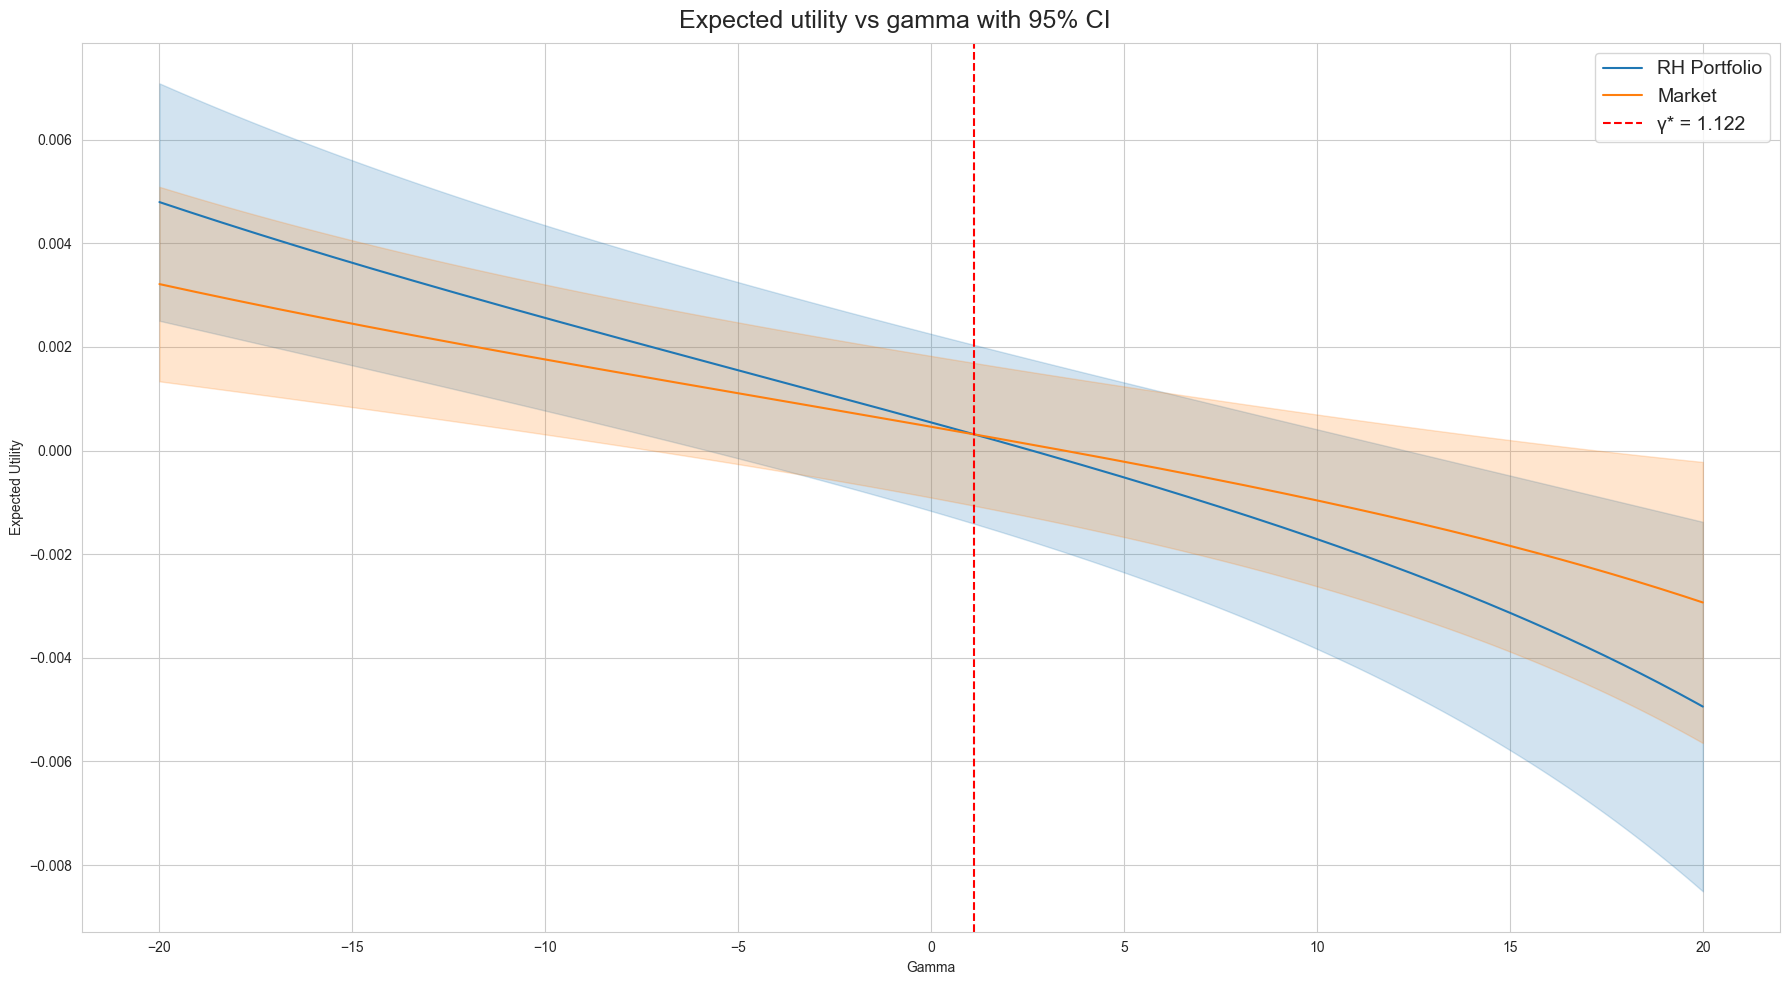

np.float64(1.1216008776527822)

In [58]:
rt.find_cutoff_gamma(bounds=(-20,20))

In [3]:
df = daily_factors +1
df

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,1.007979,1.00006,1.005061,1.007919,1.005001
2018-06-05,1.007667,1.00006,0.999735,1.007607,0.999675
2018-06-06,1.009567,1.00006,1.008749,1.009507,1.008689
2018-06-07,0.995441,1.00006,0.996583,0.995381,0.996523
2018-06-08,1.003475,1.00006,1.002242,1.003415,1.002182
...,...,...,...,...,...
2020-08-07,0.996141,1.00000,0.996542,0.996141,0.996542
2020-08-10,1.019014,1.00000,1.002726,1.019014,1.002726
2020-08-11,0.980078,1.00000,0.996910,0.980078,0.996910
2020-08-12,1.006672,1.00000,1.015001,1.006672,1.015001


In [14]:
rt.bootstrap_difference_utility(df_returns=df, gamma0=gamma_gmm)

ΔU (xmkt - rh_portfolio) at γ=3.071: -0.00017 [-0.00097, 0.00061]


(np.float64(-0.00017284581852384324),
 np.float64(-0.0009742359888587294),
 np.float64(0.0006114926814635308))

In [39]:
daily_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,0.007979,0.00006,0.005061,0.007919,0.005001
2018-06-05,0.007667,0.00006,-0.000265,0.007607,-0.000325
2018-06-06,0.009567,0.00006,0.008749,0.009507,0.008689
2018-06-07,-0.004559,0.00006,-0.003417,-0.004619,-0.003477
2018-06-08,0.003475,0.00006,0.002242,0.003415,0.002182
...,...,...,...,...,...
2020-08-07,-0.003859,0.00000,-0.003458,-0.003859,-0.003458
2020-08-10,0.019014,0.00000,0.002726,0.019014,0.002726
2020-08-11,-0.019922,0.00000,-0.003090,-0.019922,-0.003090
2020-08-12,0.006672,0.00000,0.015001,0.006672,0.015001


In [114]:
rt.bootstrap_gamma(daily_factors)

γ̂^GMM = 3.0715
95% BCa CI = [0.9072, 19.8172]


{'gamma_estimate': np.float64(3.0714922378400455),
 'ci_lower': np.float64(0.9072428346440041),
 'ci_upper': np.float64(19.817195964133305),
 'confidence_level': 0.95,
 'n_resamples': 5000}

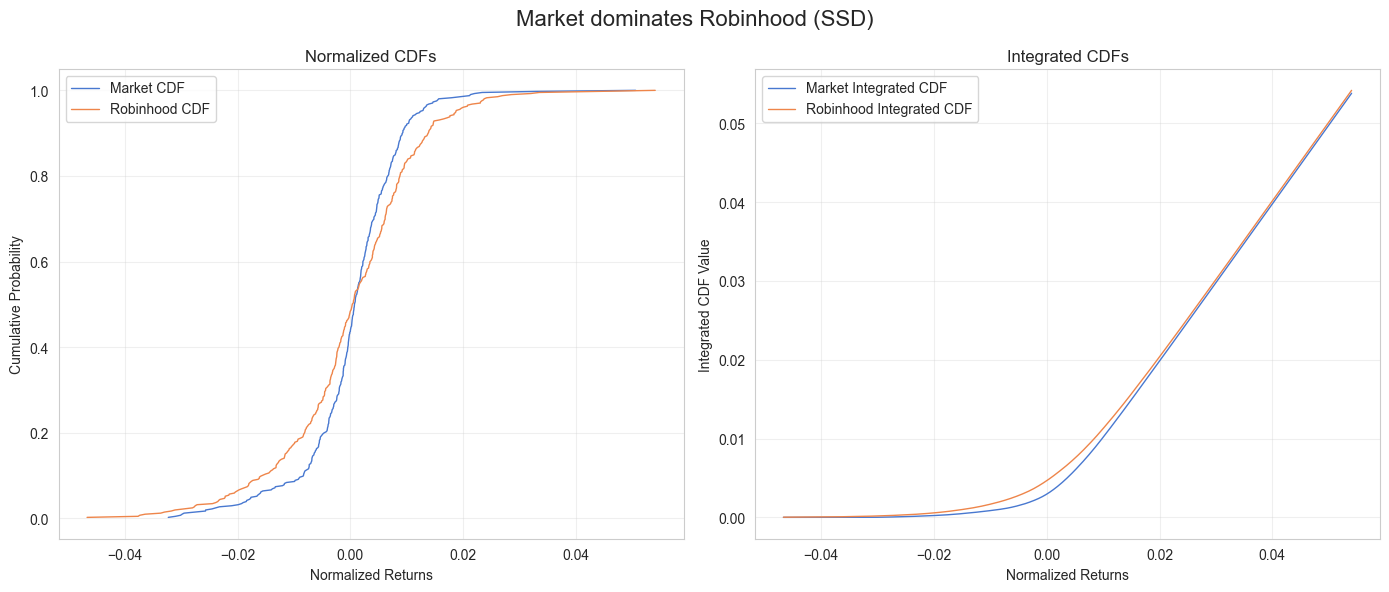

np.True_

In [45]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=daily_factors, horizons=[])])
plotter.plot_ssd_comparison(daily_factors["mkt"], daily_factors["rh_portfolio"], "Market", "Robinhood")

## $\gamma$ in a given interval

In [1]:
%load_ext autoreload 
%autoreload 2

In [162]:
import numpy as np
import pandas as pd

from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams



return_params = ReturnParams(
    horizons={30},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=["VOO"], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})
rt = RiskTests(an, ff_mkt_index=False)

2025-05-20 19:33:24,065 - src.analyzer - INFO - ------------------------------ Analysis Started ------------------------------ (analyzer.py:80)


### Estimating $\gamma$ in closed form

In [163]:
def gamma_closed_form(col, alpha):
    mu = col.mean()
    s2 = col.var()



    gamma = mu/(alpha*s2)
    return gamma

In [197]:
d = 802
rt.resample_factors(f"{d}D")

,xmkt,smb,hml,rmw,cma,rf,umd,rh_portfolio,mkt,xr
2018-06-04,0.15282,-0.213079,-0.356605,0.089409,-0.032212,0.036033,0.00116,0.178502,0.194371,0.137457


             xmkt          xr
count  802.000000  802.000000
mean     0.000264    0.000280
std      0.013091    0.015409
min     -0.117448   -0.118864
25%     -0.001024   -0.002997
50%      0.000000    0.000000
75%      0.003347    0.005230
max      0.095304    0.075465


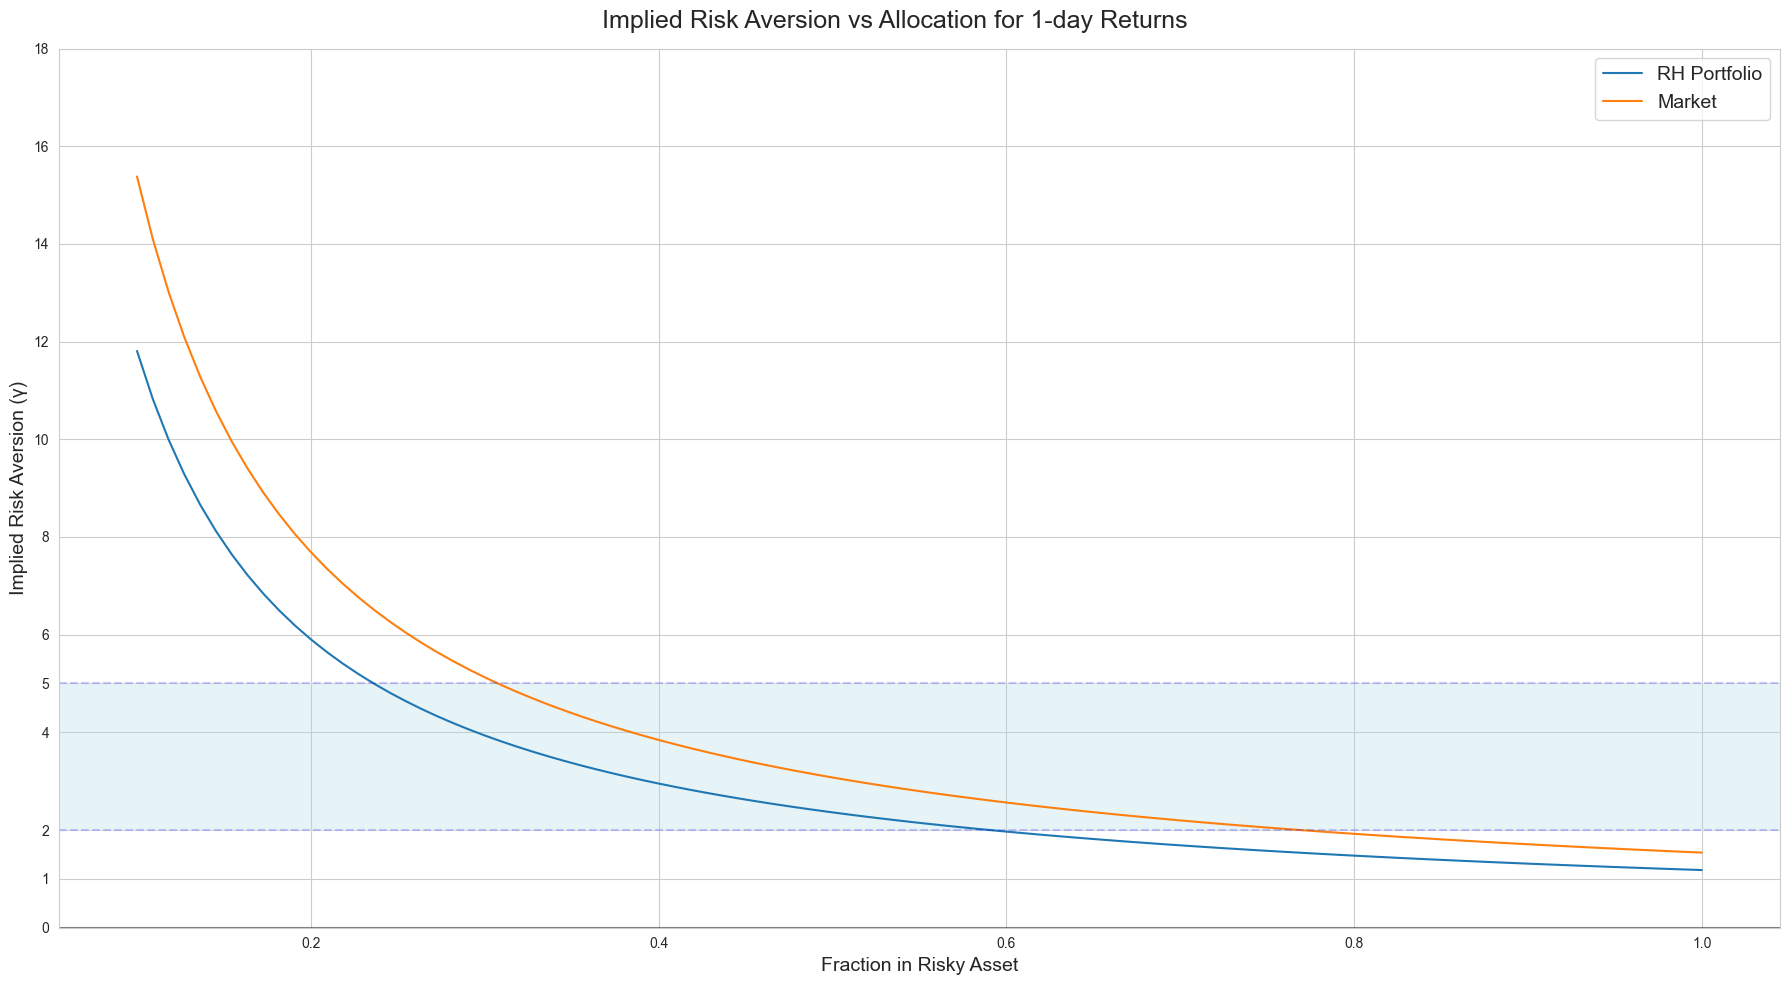

In [199]:

import matplotlib.pyplot as plt
import seaborn as sns

mkt = "xmkt"

d = 1

df = rt.resample_factors(f"{d}D")
#print(df_roll.index[0])
#df = df[df.index>="2018-07-16"]
#df = df[df.index<="2020-02-03"]
print(df[["xmkt", "xr"]].describe())


alphas = np.linspace(0.1, 1, 100)

utilities_rh_portfolio   = [gamma_closed_form(df["xr"], a) for a in alphas]
utilities_xmkt = [gamma_closed_form(df[mkt], a) for a in alphas]


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume df, gamma_closed_form, alphas, utilities_rh_portfolio, utilities_xmkt are already defined

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(18, 10))

# Highlight the γ range between 1 and 5
ax.axhspan(2, 5, facecolor='lightblue', alpha=0.3)

# Plot RH portfolio
sns.lineplot(x=alphas, y=utilities_rh_portfolio, ax=ax, label='RH Portfolio')

# Plot market and negative market
sns.lineplot(x=alphas, y=utilities_xmkt, ax=ax, label='Market')
#sns.lineplot(x=alphas, y=[-u for u in utilities_xmkt], ax=ax, label='Negative Market')

# Horizontal reference lines
ax.axhline(0, color='black', alpha=0.5)
ax.axhline(2, color='blue', linestyle="--", alpha=0.2)
ax.axhline(5, color='blue', linestyle="--", alpha=0.2)

# Labels and title
ax.set_xlabel('Fraction in Risky Asset', fontsize=14)
ax.set_ylim(0)
ax.set_ylabel('Implied Risk Aversion (γ)', fontsize=14)
fig.suptitle(f'Implied Risk Aversion vs Allocation for {d}-day Returns', fontsize=18)

# grab the current ticks
current = list(ax.get_yticks())

# make sure 1 and 5 are in there
for y in (1, 5):
    if y not in current:
        current.append(y)

# sort them
current = sorted(current)

# re-apply
ax.set_yticks(current)


ax.legend(fontsize=14)
plt.tight_layout()
plt.show()
